In [102]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque

Input shape: (1000, 2)
Output shape: (1000, 2)


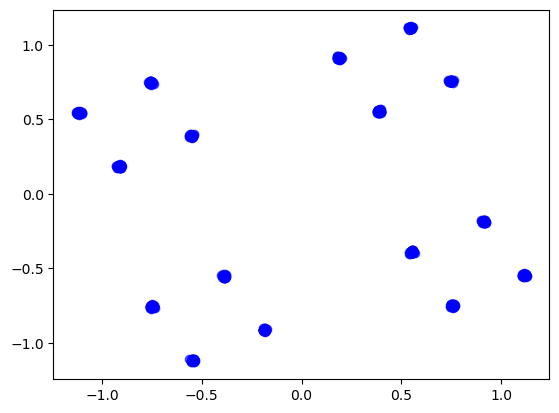

In [103]:
def apply_pmd(E_in, DGD_ps_per_sqrt_km, L_m, N_sections, Rs, SpS):
    N_samples = E_in.shape[0]
    SD_tau = np.sqrt(3 * np.pi / 8) * DGD_ps_per_sqrt_km

    tau = (SD_tau * np.sqrt(L_m * 1e-3) / np.sqrt(N_sections)) * 1e-12
    #tau=0
    w = 2 * np.pi * np.fft.fftshift(np.linspace(-0.5, 0.5, N_samples)) * SpS * Rs

    E_V = np.fft.fft(E_in[:, 0])
    E_H = np.fft.fft(E_in[:, 1])

    for _ in range(N_sections):
        # Random complex coupling matrices (unitary)
        X = np.random.randn(2, 2) + 1j * np.random.randn(2, 2)
        U, _, Vh = np.linalg.svd(X)
        V = Vh.conj().T
        #print("U is",U)
        # Rotate fields by U†
        E1 = U[0, 0].conj() * E_V + U[0, 1].conj() * E_H
        E2 = U[1, 0].conj() * E_V + U[1, 1].conj() * E_H

        # Apply differential delay
        E1 *= np.exp(1j * w * tau / 2)
        E2 *= np.exp(-1j * w * tau / 2)

        # Rotate by V
        E_V = V[0, 0] * E1 + V[0, 1] * E2
        E_H = V[1, 0] * E1 + V[1, 1] * E2

    E_out_x = np.fft.ifft(E_V)
    E_out_y = np.fft.ifft(E_H)

    return np.column_stack((E_out_x, E_out_y))


N_symbols = 1000
levels = np.array([-1, 1]) / np.sqrt(2)
qam_symbols_x = (np.random.choice(levels, N_symbols) +
               1j * np.random.choice(levels, N_symbols))
qam_symbols_y = (np.random.choice(levels, N_symbols) +
               1j * np.random.choice(levels, N_symbols))

E_in = np.column_stack((qam_symbols_x, qam_symbols_y))  # shape (100, 2)

# check parameters with deepa ma'am
E_out = apply_pmd( 
E_in=E_in, 
DGD_ps_per_sqrt_km=0.05, # typical mean DGD 
L_m=10000, # fiber length
N_sections=20, # number of fiber sections 
Rs=32e9, # 32 gbaud    We want dgd to be about 5 symbols 
SpS=2 # samples per symbol 
)

print("Input shape:", E_in.shape)
print("Output shape:", E_out.shape)

plt.scatter(E_out[:,0].real, E_out[:,0].imag, color='blue', label='Input X-pol', alpha=0.6)



In [104]:
E_in_matrix=E_out

#Hyperparameters
tau=0.01
num_hidden_dim=64
replay_buffer_cap=10000
sampling_batch_size=64



In [105]:
def cma_error_dualpol(E_out, radii=[np.sqrt(1)]):

    xpol = E_out[:, 0]/ np.sqrt(np.mean(np.abs(E_out[:, 0])**2))
    ypol = E_out[:, 1]/ np.sqrt(np.mean(np.abs(E_out[:, 1])**2))



    e_total = 0.0

    for x_cap, y_cap in zip(xpol, ypol):
        R_x = min(radii, key=lambda r: abs(np.abs(x_cap) - r))
        R_y = min(radii, key=lambda r: abs(np.abs(y_cap) - r))

        e_x = (np.abs(x_cap)**2 - R_x**2)**2
        e_y = (np.abs(y_cap)**2 - R_y**2)**2
        e_total += e_x + e_y

    return e_total / len(xpol)

def compute_reward(E_out):
    return -cma_error_dualpol(E_out)

print(cma_error_dualpol(E_in_matrix))
print(cma_error_dualpol(E_in))


0.3172166434978817
0.0


In [106]:
class QNetwork(nn.Module):
    def __init__(self, num_coeffs, hidden_dim=256):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(2 * num_coeffs, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.temp1=nn.Linear(hidden_dim,hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 2 * num_coeffs * 2)  # 4 channel * 3 coeffs per channel * real and imag parts for each coeff * inc/dec each
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x=F.leaky_relu(self.temp1(x))
        return self.fc3(x)

In [107]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state):
        self.buffer.append((state, action, reward, next_state))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states = zip(*batch)
        return (
            torch.FloatTensor(states),
            torch.LongTensor(actions),
            torch.FloatTensor(rewards),
            torch.FloatTensor(next_states)
        )

    def __len__(self):
        return len(self.buffer)

In [108]:
class DQNAgent:
    def __init__(self, num_coeffs, delta=0.01, gamma=0.99, lr=0.005):
        self.num_coeffs = num_coeffs
        self.num_actions=2*num_coeffs*2
        self.delta = delta
        self.gamma = gamma

        self.q_net = QNetwork(num_coeffs)
        self.target_net = QNetwork(num_coeffs)
        self.target_net.load_state_dict(self.q_net.state_dict())

        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=lr)
        self.replay_buffer = ReplayBuffer()
        self.loss_fn = nn.MSELoss()

    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, self.num_actions - 1)
        with torch.no_grad():
            q_vals = self.q_net(torch.FloatTensor(state))
            return torch.argmax(q_vals).item()

    def update(self, batch_size=64):
        if len(self.replay_buffer) < batch_size:
            return None
        states, actions, rewards, next_states = self.replay_buffer.sample(batch_size)
        q_vals = self.q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            next_q_vals = self.target_net(next_states).max(1)[0]
            targets = rewards + self.gamma * next_q_vals
        loss = self.loss_fn(q_vals, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def soft_update(self, tau=0.01):
        for target_param, param in zip(self.target_net.parameters(), self.q_net.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

In [109]:
def apply_filters(E_in, pxx, pxy, pyx, pyy):
    x_in, y_in = E_in[:, 0], E_in[:, 1]
    x_out = np.convolve(x_in, pxx, mode='same') + np.convolve(y_in, pxy, mode='same')
    y_out = np.convolve(x_in, pyx, mode='same') + np.convolve(y_in, pyy, mode='same')
    return np.column_stack((x_out, y_out))

def get_filter_tap_type_from_action_index(action_index,total_num_actions):
    #I number it in such a way that it is like filter0-tap0-real,filter0-tap0-imag,filter0-tap1-real,so on.
    num_filters=4
    num_taps_per_filter=3
    filt_idx = action_index // 12   #Has indexes from 0 to 3
    tap_idx = (action_index // 4) % num_taps_per_filter #
    part = (action_index // 2) % 2  # 0=real, 1=imag
    direction = 1 if action_index % 2 == 0 else -1

    return filt_idx,tap_idx,part,direction
    #return filter_ind,taps_ind,real_index

print(get_filter_tap_type_from_action_index(11,48))

(0, 2, 1, -1)


In [110]:
num_taps = 3
num_coeffs = num_taps * 4   # 4 channels * 3 taps = 12 complex coeffs
num_episodes = 400
steps_per_episode = 100
delta = 0.02

agent = DQNAgent(num_coeffs=num_coeffs, delta=delta,lr=5e-4)
epsilon, epsilon_min, epsilon_decay = 1.0, 0.05, 0.995

for episode in range(num_episodes):
    # initialize filter weights
    pxx =  [(0.19278588742874891+0.13659670282519232j), (0.5184388346473833-0.5003078897671651j), (0.718335683460289+0.8954418804765679j)]
    pxy =  [(0.6218276414993511-0.39189081610647436j), (0.5600745006595894+0.6758716110364135j), (0.09195882344299255+0.8283914307009889j)]
    pyx =  [(0.4490470782749889+0.8029232400353175j), (0.4795070851702994-0.6948455559193323j), (0.32420210797652127+0.04877111021697689j)]
    pyy =  [(0.22222171226176357-0.6656413597730969j), (0.15826636212898026+0.8327775913293115j), (0.7921226200898618+0.24991332750261175j)]

    # ideal coefficients:

    # state = real and imag parts of all coefficients
    state = np.concatenate([
        np.real(np.concatenate([pxx, pxy, pyx, pyy])),
        np.imag(np.concatenate([pxx, pxy, pyx, pyy]))
    ])
    #print(state)



    for t in range(steps_per_episode):

        action = agent.select_action(state, epsilon) #Here action represents the output action index selected
        #print(action)
        
        #action number is between 0 to 47 and filt index will be 
        filt_idx = action // num_coeffs   #Has indexes from 0 to 3
        tap_idx = (action // 4) % num_taps #
        part = (action // 2) % 2  # 0=real, 1=imag
        direction = 1 if action % 2 == 0 else -1

        filters = [pxx, pxy, pyx, pyy]
        filt = filters[filt_idx]

        # update chosen coefficient
        if part == 0:
            filt[tap_idx] += direction * delta
        else:
            filt[tap_idx] += 1j * direction * delta
        filters[filt_idx] = filt

        E_out = apply_filters(E_in_matrix, *filters)
        reward = compute_reward(E_out)

        next_state = np.concatenate([
            np.real(np.concatenate(filters)),
            np.imag(np.concatenate(filters))
        ])

        agent.replay_buffer.push(state, action, reward, next_state)
        state = next_state
        loss = agent.update()
        agent.soft_update(tau=0.5)

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if (episode + 1) % 5 == 0:
        print(f"Episode {episode+1}, epsilon={epsilon:.3f}, last_loss={loss:.6f}, reward={reward:.6f}")

print("\nTraining complete")
print("Final filters:")
print("pxx = ", pxx)
print("pxy = ", pxy)
print("pyx = ", pyx)
print("pyy = ", pyy)

Episode 5, epsilon=0.975, last_loss=0.036931, reward=-1.514218
Episode 10, epsilon=0.951, last_loss=0.200547, reward=-1.511474
Episode 15, epsilon=0.928, last_loss=0.094880, reward=-1.546430
Episode 20, epsilon=0.905, last_loss=0.298706, reward=-1.555506
Episode 25, epsilon=0.882, last_loss=0.099677, reward=-1.503843
Episode 30, epsilon=0.860, last_loss=0.390808, reward=-1.544185
Episode 35, epsilon=0.839, last_loss=0.057015, reward=-1.512735
Episode 40, epsilon=0.818, last_loss=0.384696, reward=-1.523449
Episode 45, epsilon=0.798, last_loss=0.024161, reward=-1.498502
Episode 50, epsilon=0.778, last_loss=0.067526, reward=-1.530220
Episode 55, epsilon=0.759, last_loss=0.092437, reward=-1.521594
Episode 60, epsilon=0.740, last_loss=0.062393, reward=-1.522085
Episode 65, epsilon=0.722, last_loss=0.044885, reward=-1.525479
Episode 70, epsilon=0.704, last_loss=0.090606, reward=-1.523824
Episode 75, epsilon=0.687, last_loss=0.154164, reward=-1.541446
Episode 80, epsilon=0.670, last_loss=0.21

KeyboardInterrupt: 

In [ ]:
print(agent.update())
print(agent.q_net.fc1.weight.grad)

0.04564617574214935
tensor([[-2.8248e-04, -7.6612e-04, -1.0784e-03,  ...,  9.7294e-04,
         -1.2173e-03, -3.7463e-04],
        [ 3.3409e-04,  9.0631e-04,  1.2754e-03,  ..., -1.1513e-03,
          1.4400e-03,  4.4317e-04],
        [-3.3573e-02, -9.1080e-02, -1.2811e-01,  ...,  1.1568e-01,
         -1.4471e-01, -4.4528e-02],
        ...,
        [ 6.0574e-06,  1.0679e-05,  1.7360e-05,  ..., -1.4769e-05,
          1.9118e-05,  4.9872e-06],
        [-8.6772e-07, -2.6139e-06, -3.8371e-06,  ...,  3.6220e-06,
         -4.1677e-06, -1.2988e-06],
        [ 3.0954e-04,  8.4120e-04,  1.1830e-03,  ..., -1.0680e-03,
          1.3359e-03,  4.1131e-04]])
